In [1]:
import napari
import zarr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import get_single_volume
from DLC_for_WBFM.utils.projects.utils_project import load_config
from pathlib import Path
from DLC_for_WBFM.utils.projects.utils_project import safe_cd
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_tracks
from DLC_for_WBFM.utils.preprocessing.utils_tif import PreprocessingSettings
from DLC_for_WBFM.utils.preprocessing.utils_tif import perform_preprocessing
from DLC_for_WBFM.utils.preprocessing.utils_tif import preprocess_all_frames_using_config
import os
%load_ext autoreload
%autoreload 2

In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

In [2]:
# Set up project

project_path = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-gfp-long\project_config.yaml"
cfg = load_config(project_path)

red_btf = cfg['red_bigtiff_fname']
num_z = cfg['dataset_params']['num_slices']

project_dir = Path(project_path).parent

with safe_cd(project_dir):
    seg_fname = Path(cfg['subfolder_configs']['segmentation'])
    seg_cfg = dict(load_config(seg_fname))
    
    train_fname = Path(cfg['subfolder_configs']['training_data'])
    train_cfg = dict(load_config(train_fname))
    
    track_fname = Path(cfg['subfolder_configs']['tracking'])
    track_cfg = dict(load_config(track_fname))
    
    p_fname = train_cfg['preprocessing_config']
    p = PreprocessingSettings.load_from_yaml(p_fname)
    
    cfg['preprocessing_config'] = p_fname

In [3]:
# Import segmentation
fname = seg_cfg['output']['masks']
with safe_cd(project_dir):
    raw_segmentation = zarr.open(fname)

fname = os.path.join('4-traces', 'reindexed_masks.zarr')
with safe_cd(project_dir):
    reindexed_segmentation = zarr.open(fname)

In [4]:
# Import DLC tracks
fname = track_cfg['final_3d_tracks']['df_fname']
with safe_cd(project_dir):
    df = pd.read_hdf(fname)

In [5]:
# %%timeit
# Load raw data (.btf)
with safe_cd(project_dir):
    dat, _ = preprocess_all_frames_using_config(DEBUG=False, config=cfg, verbose=2, vid_fname=red_btf)

Preprocessing data, this could take a while...


  0%|          | 0/3000 [00:00<?, ?it/s]

In [12]:
# ALSO: save it!
# out_fname = Path(red_btf).with_suffix('.zarr')
# out_fname = "tmp.zarr"
# zarr.save_array(str(out_fname), dat)

# Check which track to do

In [13]:
# napari.view_image(dat)

In [15]:
viewer = napari.view_image(dat)
viewer.add_labels(reindexed_segmentation)

<Labels layer 'reindexed_segmentation' at 0x278a0366a48>

In [65]:
# Check the tracks
from ipywidgets import interact
def f(i):
    name = df.columns.levels[0][i]
    print(df[name])
    print(name)
interact(f, i=(0,len(df.columns.levels[0])-1))

interactive(children=(IntSlider(value=30, description='i', max=61), Output()), _dom_classes=('widget-interact'…

<function __main__.f(i)>

# Full overlay: data, segmentation, and DLC points

In [128]:
# Start: one neuron
neuron_names = ['neuron4453']
# 5 columns: 
# track_id, t, z, y, x
coords = ['z', 'y', 'x']
all_tracks_list = []
likelihood_thresh = 0.4
for i, name in enumerate(neuron_names):
    zxy_array = np.array(df[name][coords])
    t_array = np.expand_dims(np.arange(zxy_array.shape[0]), axis=1)
    # Remove low likelihood
    to_keep = df[name]['likelihood'] > likelihood_thresh
    zxy_array = zxy_array[to_keep,:]
    t_array = t_array[to_keep,:]
    
    all_tracks_list.append(np.hstack([t_array, zxy_array]))
    
all_tracks_array = np.vstack(all_tracks_list)

In [129]:
current_points = all_tracks_array
current_points_star = current_points # Not made to edit; only 2d version
opt = dict(face_color='white', size=4)

viewer = napari.view_image(dat, ndisplay=3)
viewer.add_labels(reindexed_segmentation)
viewer.add_labels(raw_segmentation)
viewer.add_points(current_points, edge_color='blue', n_dimensional=True, symbol='square', **opt)
viewer.add_points(current_points_star, edge_color='red', symbol='star', **opt)

<Points layer 'current_points_star' at 0x1df6e7f1e48>

C:\Users\charles.fieseler\Anaconda3\envs\DLC-for-WBFM\lib\site-packages\napari\layers\labels\labels.py:927: UserWarning: Contours are not displayed during 3D rendering
  deferred=True,


# Save the manually tracked point

In [18]:
name

NameError: name 'name' is not defined

In [16]:
new_points = viewer.layers['current_points'].data

col = pd.MultiIndex.from_product([neuron_names, ['t', 'z', 'x', 'y']])
df_new = pd.DataFrame(columns=col)

df_new[(name, 't')] = new_points[:,0]
df_new[(name, 'z')] = new_points[:,1]
df_new[(name, 'y')] = new_points[:,2]
df_new[(name, 'x')] = new_points[:,3]

df_new.sort_values((name,'t'), inplace=True, ignore_index=True)


KeyError: "'current_points' is not in list"

In [131]:
out_fname

'Y:\\shared_projects\\wbfm\\dlc_stacks\\Charlie-worm3-long\\3-tracking\\manual_tracking\\neuron4207.csv'

In [132]:
out_fname = os.path.join(project_dir, '3-tracking', 'manual_tracking', f'{name}.h5')
# df_new.to_hdf(out_fname)

out_fname = str(Path(out_fname).with_suffix('.csv'))
df_new.to_csv(out_fname)

# Visualize the annotations

In [122]:
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\3-tracking\manual_tracking\worm3_neurons.xlsx"
df_error_codes = pd.read_excel(fname, sheet_name=name)

fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\4-traces\red_traces.h5"
df_red = pd.read_hdf(fname)

fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\4-traces\green_traces.h5"
df_green = pd.read_hdf(fname)

Text(0.5, 1.0, 'Trace (ratio)')

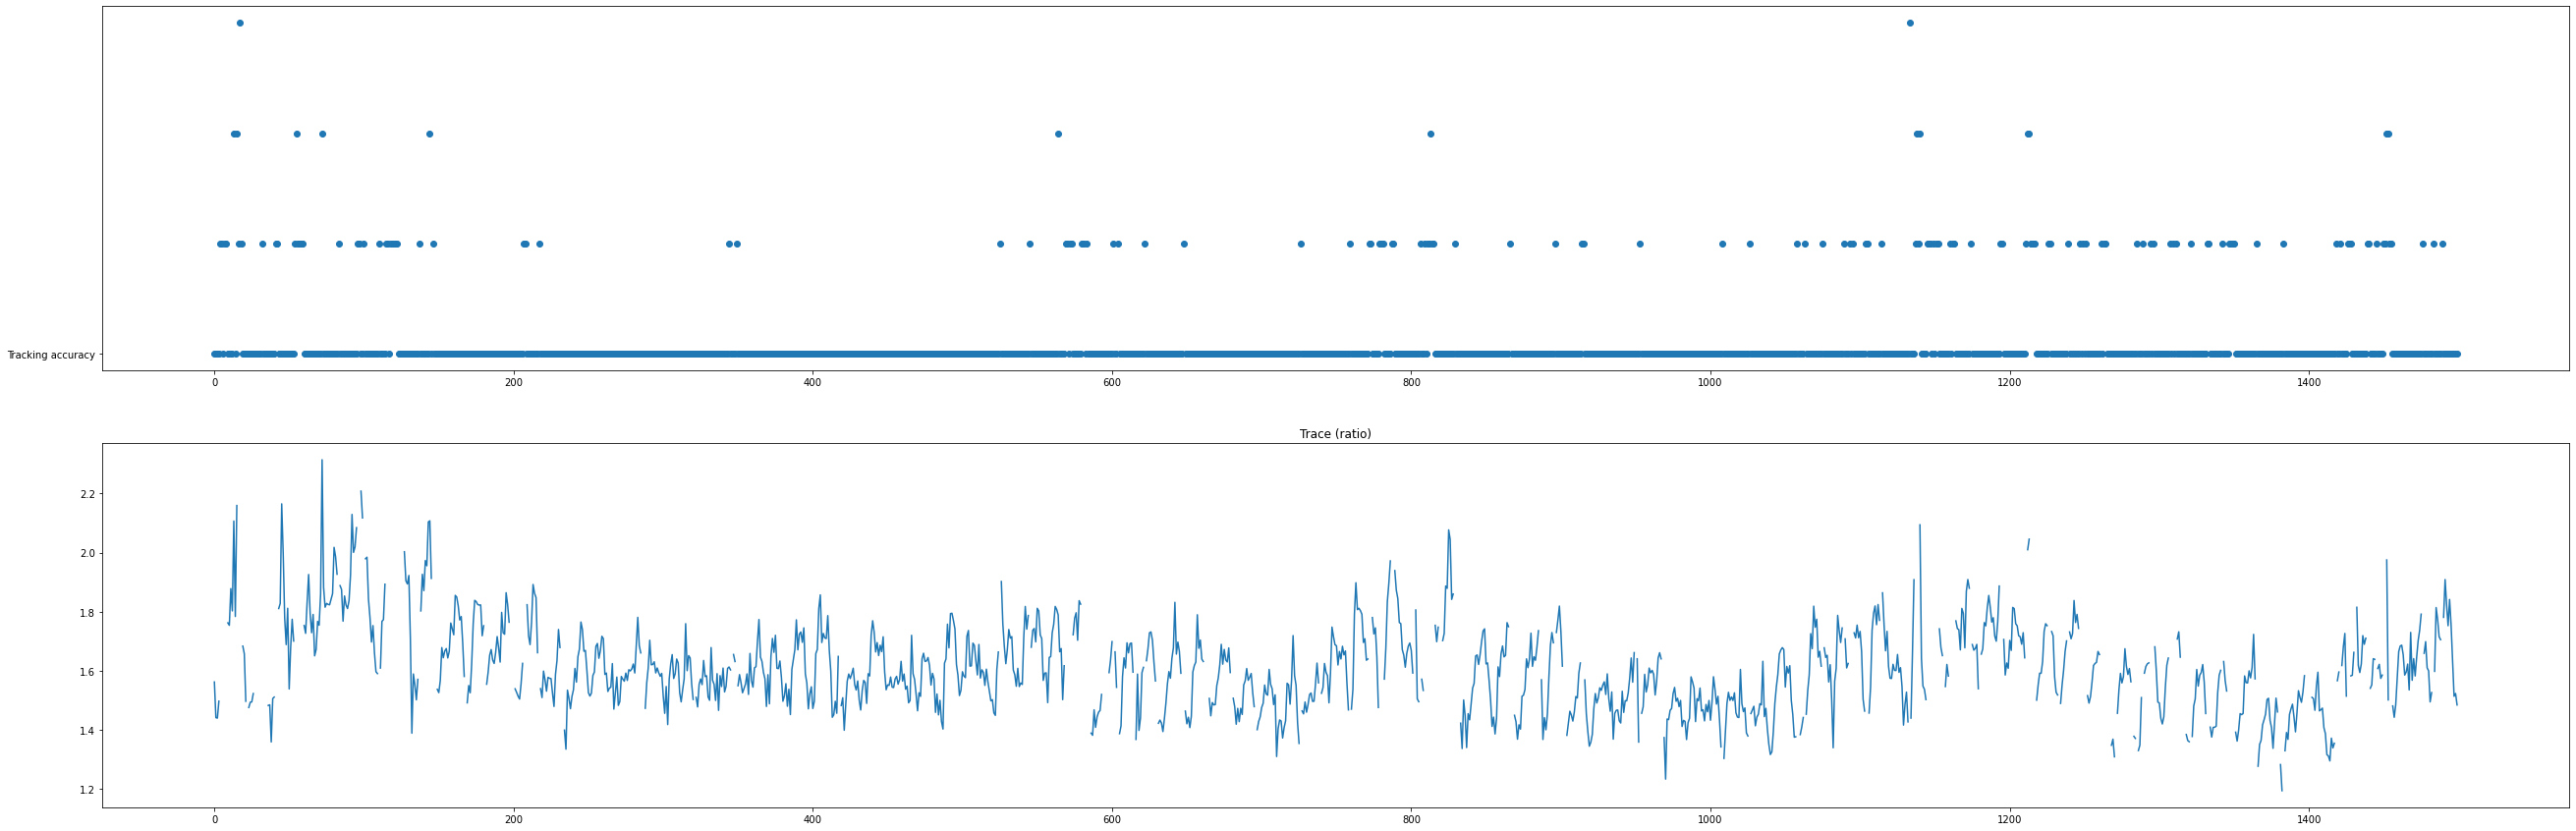

In [124]:
plt.figure(figsize=(45,15))

plt.subplot(211)
plt.plot(df_error_codes['Track Code'], 'o')
plt.plot("Tracking accuracy")

plt.subplot(212)
plt.plot(df_red[name]['brightness'] / df_green[name]['brightness'])
plt.title("Trace (ratio)")

Text(0.5, 1.0, 'Trace (ratio)')

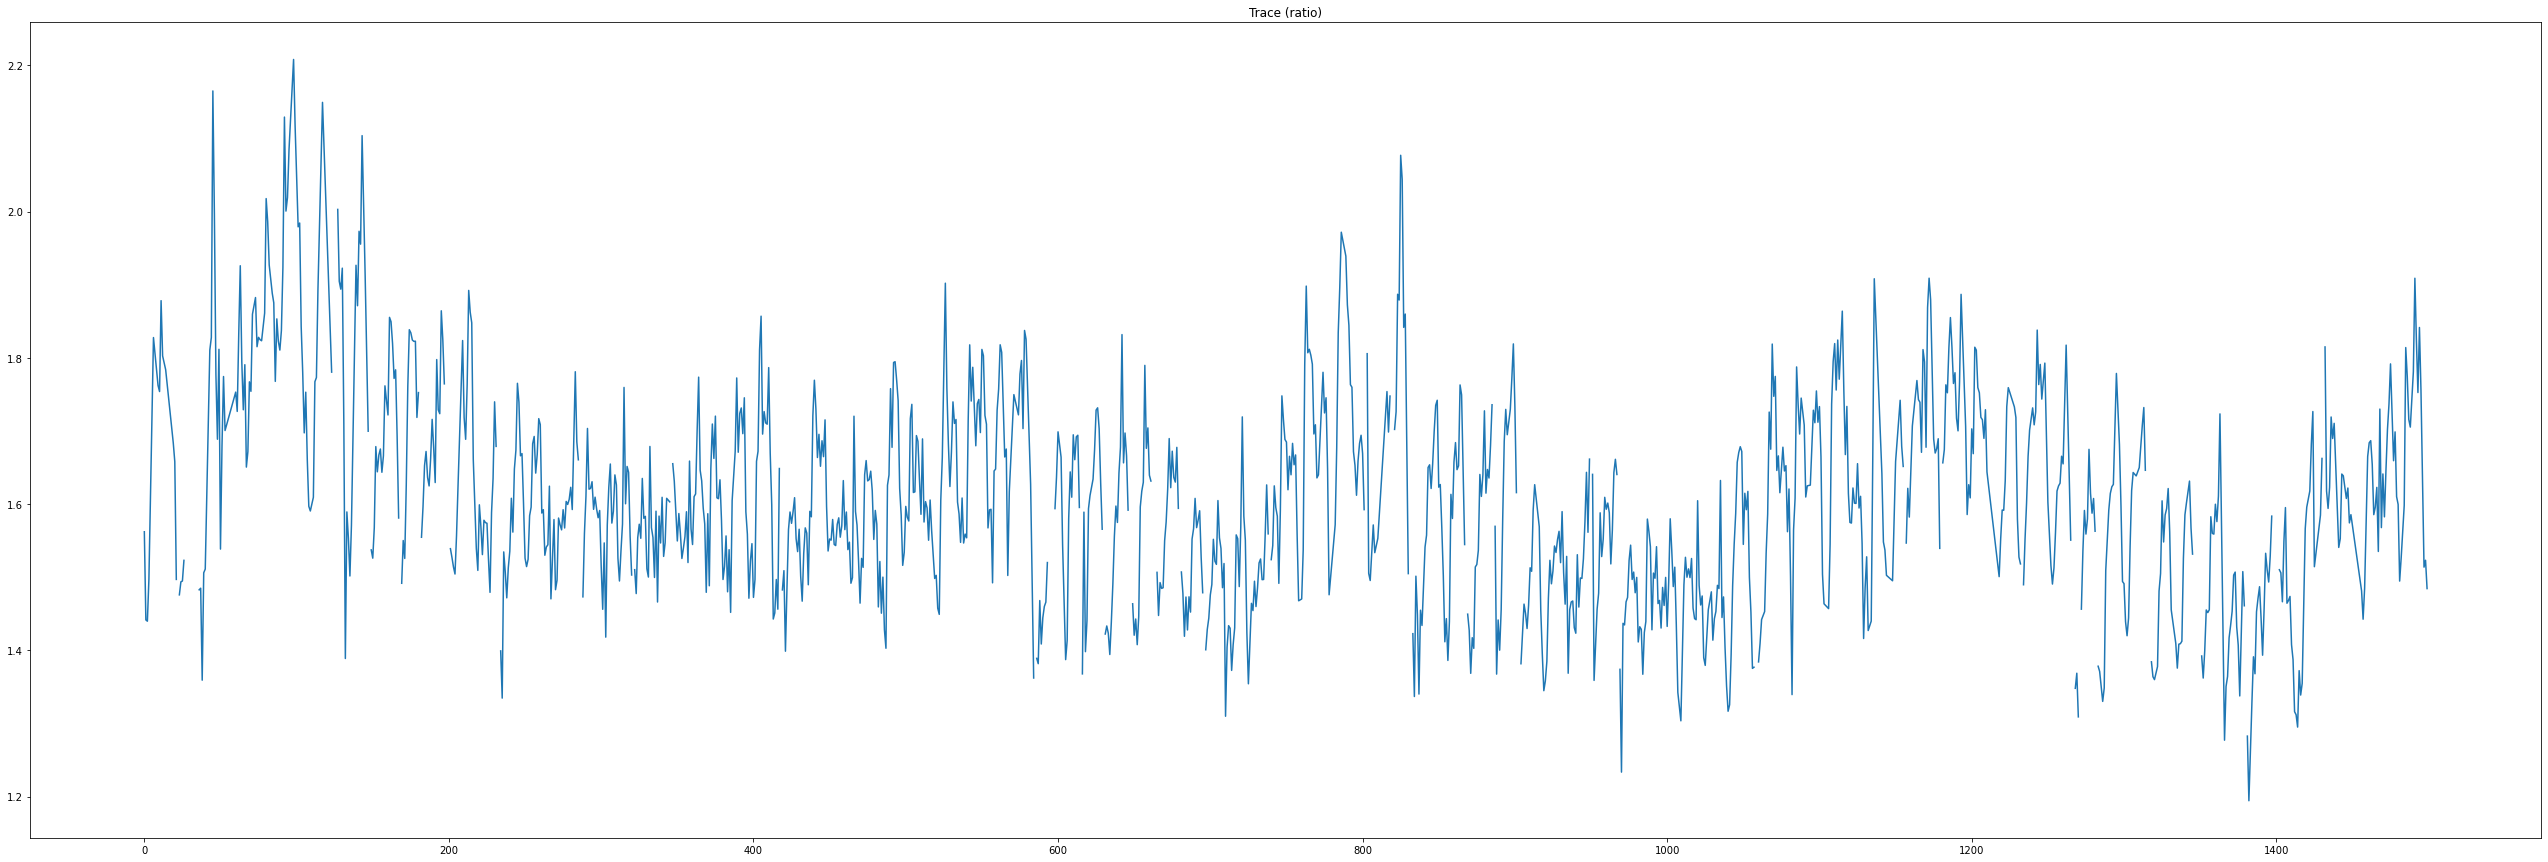

In [126]:
plt.figure(figsize=(45,15))

good_points = df_error_codes['Track Code']==0

plt.plot(df_red[name]['brightness'][good_points] / df_green[name]['brightness'][good_points])
plt.title("Trace (ratio)")

In [32]:
# Scratch with pandas


df = pd.DataFrame(index=['one', 'two', 'three'],
                  columns=['total_brightness', 'neuron_volume', 'centroids', 'pixel_values', 'pixel_counts'])


In [36]:
df.at['one','total_brightness'] = 5000
df.at['two', 'neuron_volume'] = 50
df.at['three', 'centroids'] = np.array([1,2,3])
df

,total_brightness,neuron_volume,centroids,pixel_values,pixel_counts
one,5000,NaN,NaN,NaN,NaN
two,NaN,50,NaN,NaN,NaN
three,NaN,NaN,"[1, 2, 3]",NaN,NaN


In [43]:
import concurrent.futures


In [55]:
# my_dict = dict()
my_dict = dict.fromkeys(range(10))

def get_dict_vals(i):
    data = 0.5*np.arange(i,i+3)
    my_dict[i] = pd.DataFrame(data)

with concurrent.futures.ThreadPoolExecutor(max_workers=4) as ex:
    futures = {ex.submit(get_dict_vals, i): i for i in range(10)}
    for i, future in enumerate(concurrent.futures.as_completed(futures)):
#         my_dict[i] = future.result()
        future.result()

In [56]:
my_dict

{0:      0
 0  0.0
 1  0.5
 2  1.0,
 1:      0
 0  0.5
 1  1.0
 2  1.5,
 2:      0
 0  1.0
 1  1.5
 2  2.0,
 3:      0
 0  1.5
 1  2.0
 2  2.5,
 4:      0
 0  2.0
 1  2.5
 2  3.0,
 5:      0
 0  2.5
 1  3.0
 2  3.5,
 6:      0
 0  3.0
 1  3.5
 2  4.0,
 7:      0
 0  3.5
 1  4.0
 2  4.5,
 8:      0
 0  4.0
 1  4.5
 2  5.0,
 9:      0
 0  4.5
 1  5.0
 2  5.5}

In [57]:
import pickle

In [59]:
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\1-segmentation\metadata_1500.pickle"
with open(fname, 'rb') as f:
    metadat = pickle.load(f)

<BarContainer object of 340 artists>

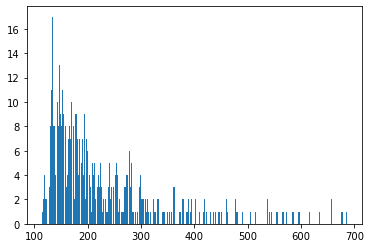

In [63]:
plt.bar(metadat[0].at[1,'pixel_values'], metadat[0].at[1,'pixel_counts'])